# Enkelt potensial
Målet er å simulere diffusjon i eit enkelt potensial

$$ V(x) = kx $$

for ein konstant $k$.

In [9]:
import matplotlib as mpl

# nice big latex-flavored plots
# if you don't have these fonts, or you don't have
# XeLaTeX installed, this needs to be modified.
fontsize = 20
newparams = {
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'lines.linewidth': 2, 
    'lines.markersize': 7,
    'text.usetex': True,
    'font.family': "serif",
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": True,
    'figure.figsize': (16,16), 
    'ytick.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.handlelength': 1.5,
    'xtick.major.pad': 8,
    'ytick.major.pad': 8,
}

# !!!
# for some reason, on some machines, you need to run this cell twice
# it probably has something to do with python versions or something
# !!!
%matplotlib inline

# makes mpl use the pgf-renderer. sometimes (but not on all machines)
# this disables rendering in the notebook.
# if this happens on your machine, maybe use
# another backend while working, and switch
# to pgf when you want to generate the final plots.

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

# right angles never hurt anyone,
# so use classic as a base theme
plt.style.use('classic')
# the gray border is not visible in the plot rendered
# by plt.savefig, so dont't  worry about that

# finally change the necessary parameters
plt.rcParams.update(newparams)

# pretty-print sympy things
sp.init_printing()

In [2]:
import scipy as scp
import scipy.constants as const
k_B = const.Boltzmann

Det er oppgitt at $k\beta$ er mellom $3$ og $5$.

In [15]:
temp = 300
beta = 1 / (k_B * temp)
k = 3 / beta

# step length
h = 0.5

V0_Na = k
V0_K  = k
L     = 50

def V_Na(x):
    if abs(x) > L / 2:
        return np.inf
    if -h <= x <= h:
        return V0_Na
    else:
        return 0
    
def V_K(x):
    if abs(x) > L / 2:
        return np.inf
    elif -h <= x <= h:
        return V0_K
    else:
        return 0

def P_r(xs, V):
    rs = np.zeros(xs.shape)
    for i, x in enumerate(xs):
        rs[i] = np.exp(-beta * (V(x + h) - V(x - h)))
    return 1 / (1 + rs)

def steps(xs, V):
    rng = np.random.random(xs.shape)
    return h * np.where(rng > P_r(xs, V), 1, -1)

Gitt $x$-verdiane kan vi beregne alle $P_R(x)$-verdiane.
Desse verdiane brukar vi for å ta steg tilfeldig.

### Spenning

In [4]:
Cc = 0.07 # * e

In [16]:
# start parameters: T = #steps
T = 1000

plot_ts = [5, 50, 150, 1000]

# N partiklar i starttilstand
Na_outside, Na_inside = 1450, 60
N_Na = Na_outside + Na_inside
Na = np.array([L/4 for _ in range(Na_outside)] \
            + [-L/4 for _ in range(Na_inside)])

K_outside, K_inside = 50, 1400
N_K = K_outside + K_inside
K  = np.array([L/4 for _ in range(K_outside)] \
            + [-L/4 for _ in range(K_inside)])

phi_K, phi_Na = dict(),  dict()

Ks_inside  = np.zeros(T + 1)
Nas_inside = np.zeros(T + 1)
Vs         = np.zeros(T + 1)

for t in range(T + 1):
    K  += steps(K, V_K)
    Na += steps(Na, V_Na)
    
    # count the particles inside
    count_K  = len(K[np.where(K < 0)])
    count_Na = len(Na[np.where(Na < 0)])
    # convert to Moles
    charge_conc = (count_K + count_Na) * 0.1 * 1e-3 # M
    
    voltage = charge_conc / Cc
    Vs[t] = voltage
    Ks_inside[t] = count_K
    Nas_inside[t] = count_Na
    
    if t in plot_ts:
        phi_K[t]  = np.copy(K)
        phi_Na[t] = np.copy(Na)

ValueError: Axis limits cannot be NaN or Inf

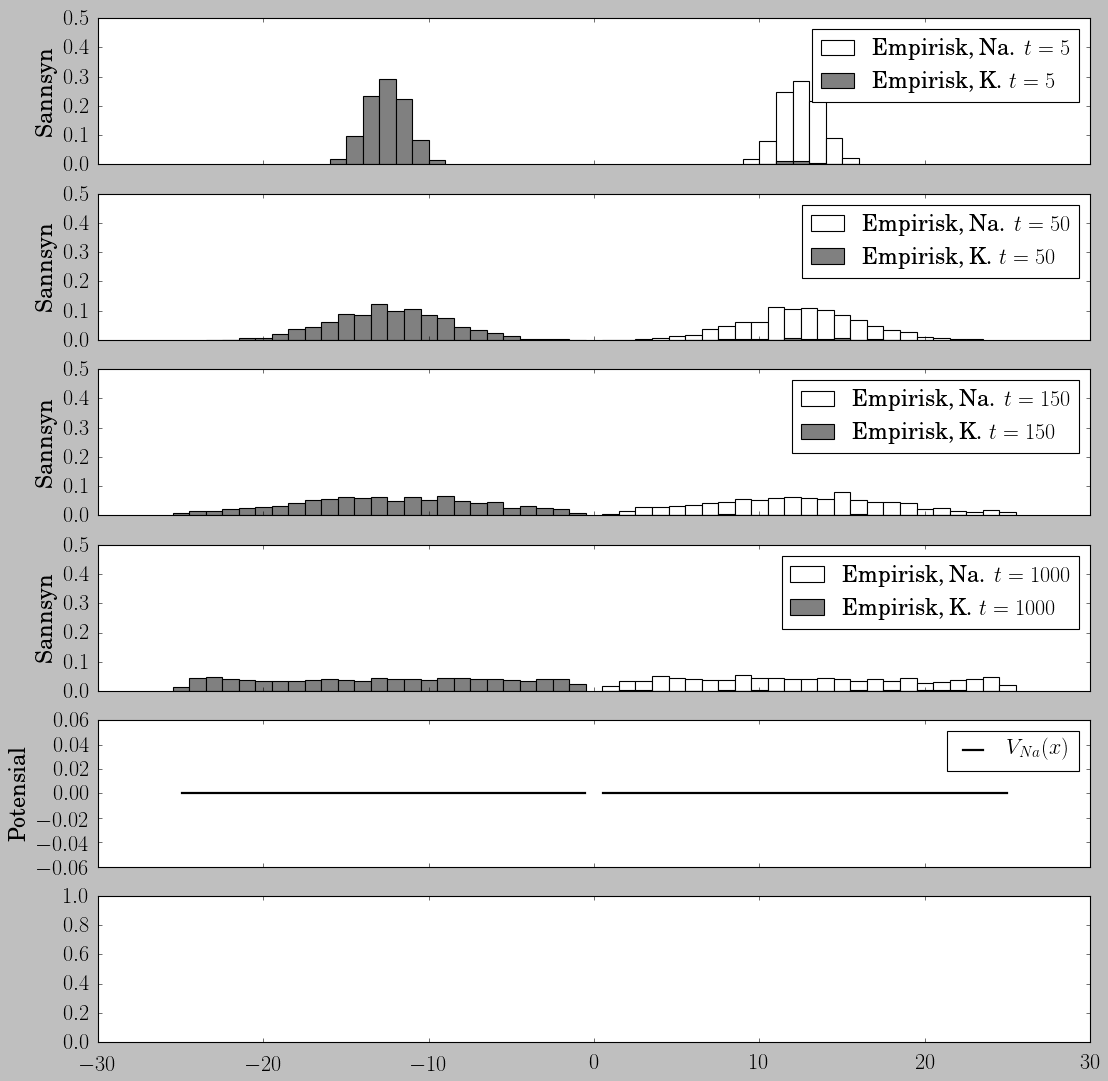

In [17]:
fig = plt.figure()
axes = fig.subplots(2 + len(plot_ts), 1, sharex=True)

ylim = (0, .5)

### plot 1
for i, t in enumerate(plot_ts):
    unique_Na, count_Na = np.unique(phi_Na[t], return_counts=True)
    unique_K,  count_K  = np.unique(phi_K[t],  return_counts=True)
    axes[i].bar(
        unique_Na, count_Na / N_Na,
        edgecolor="black",
        color='white',
        width=2*h,
        align='center',
        label='Empirisk, Na. $t = {}$'.format(t),
    )
    
    axes[i].bar(
        unique_K, count_K / N_K,
        edgecolor="black",
        color='gray',
        width=2*h,
        align='center',
        label='Empirisk, K. $t = {}$'.format(t),
    )

    axes[i].set_ylim(*ylim)
    axes[i].set_ylabel(r"Sannsyn")  
    axes[i].legend(loc='upper right')


### plot 2
xmin, xmax = plt.xlim()

xs = np.linspace(xmin, xmax, 500)
vs_Na = np.zeros(xs.shape)
vs_K  = np.zeros(xs.shape)
for i, x in enumerate(xs): vs_Na[i] = V_Na(x)
for i, x in enumerate(xs): vs_K[i]  = V_K(x)

axes[-2].plot(xs, vs_Na, 'k', label="$V_{Na}(x)$")
axes[-2].set_ylabel(r"Potensial")
axes[-2].legend(loc='upper right')
axes[-2].set_ylim(0, V0_Na * 1.1)

axes[-1].plot(xs, vs_K, 'k', label="$V_{K}(x)$")
axes[-1].set_ylabel(r"Potensial")
axes[-1].legend(loc='upper right')
axes[-1].set_ylim(0, V0_K * 1.1)

plt.xlabel(r"Posisjon")

plt.savefig("walk_7_1.pdf")

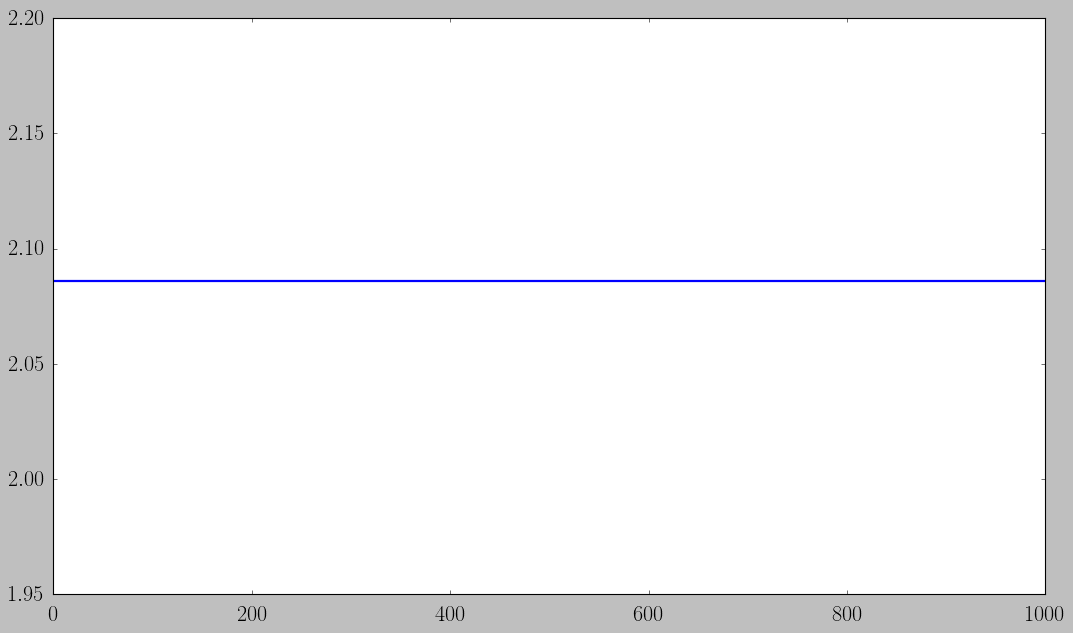

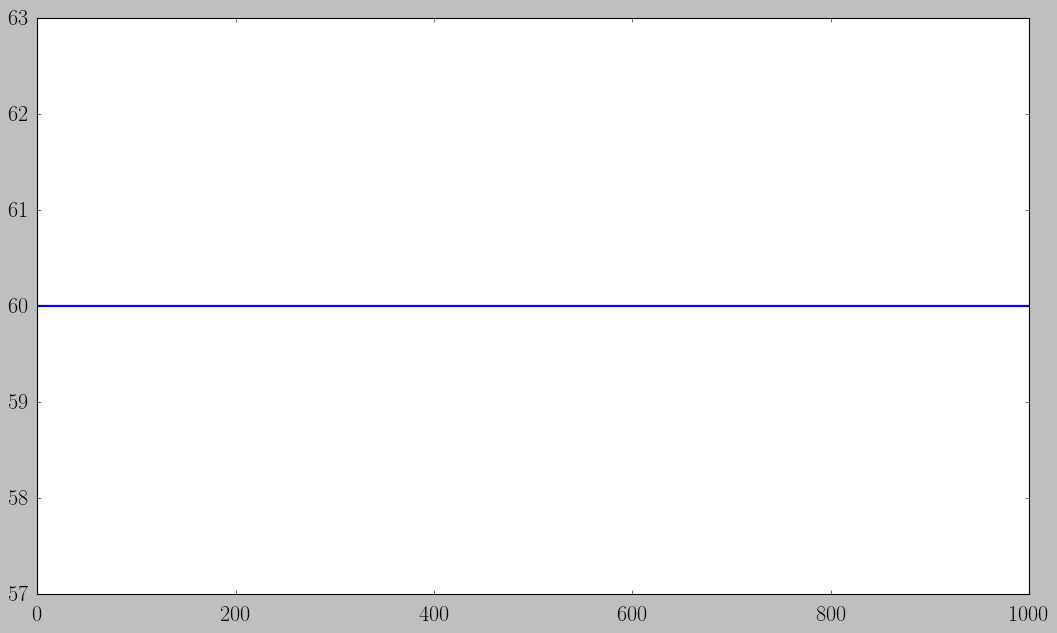

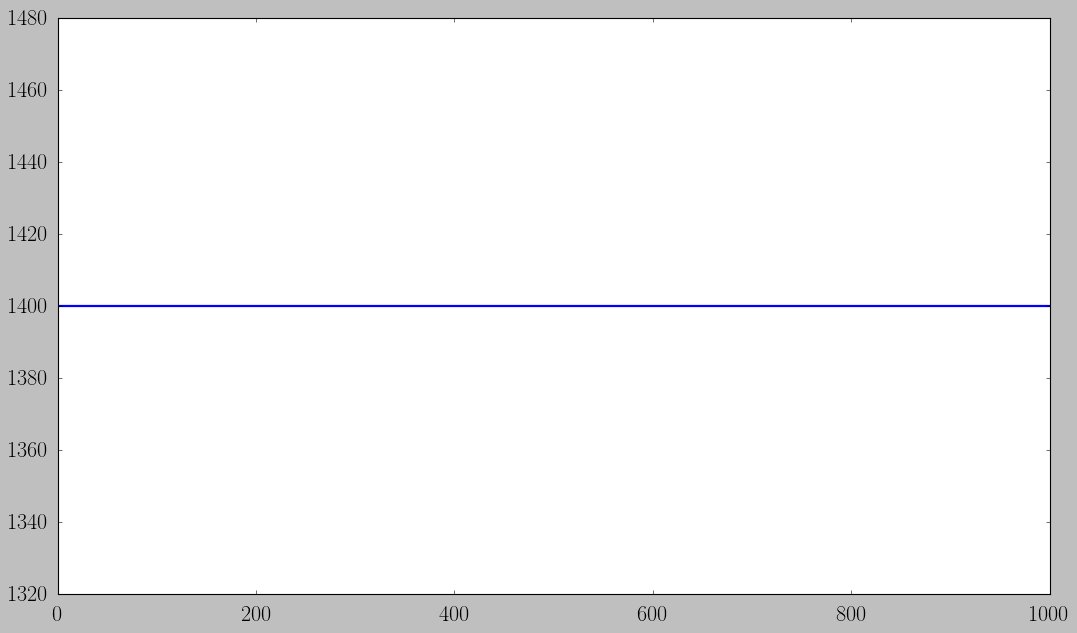

In [18]:
fig=plt.figure(figsize=(16, 9))
plt.plot(np.arange(T+1), Vs,         label="Voltage")
fig=plt.figure(figsize=(16, 9))
plt.plot(np.arange(T+1), Nas_inside, label="Na inside cell")
fig=plt.figure(figsize=(16, 9))
plt.plot(np.arange(T+1), Ks_inside,  label="K inside cell");

In [ ]:
A = np.array([1,0 ,0,0,1,1,1,1,1])
A[np.where(A == 1)]